In [1]:
import pickle as pcl

import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

In [16]:
zees = ['9p72','8p93','8p22','6p97','5p92','5p03','3p95','3p10','2p07']
zeds = [float(z.replace('p','.')) for z in zees]

### Load data

In [4]:
all_z0_halos = pd.read_csv('data/halos/all_z0_halos.csv', skiprows=14, skipfooter=1, engine='python')

In [36]:
zn_halos = dict.fromkeys(zees)
z0_halos = dict.fromkeys(zees)

for i, z in enumerate(zees[:5]):
    zn_halos[z] = pd.read_csv('data/halos/z%s_halos.csv' % z, skiprows=18, skipfooter=1, engine='python')
    zn_halos[z].columns = ['zn_m_crit200','zn_haloId']
    
    z0_halos[z] = pd.read_csv('data/halos/z0_halos_z%s.csv' % z, skiprows=41, skipfooter=1, engine='python')
    
    z0_halos[z]['zn_m_crit200'] *= 1e10 
    z0_halos[z]['z0_m_crit200'] *= 1e10

Match halos selected at $z = n$ with $z = 0$ descendants

In [37]:
def find_matches(x):        
    temp = all_z0_halos[(all_z0_halos['haloId'] < x['zn_haloId']) & \
             (all_z0_halos['lastProgenitorId'] > x['zn_haloId'])]
    
    if len(temp) == 0:
        return pd.Series({'m_crit200': np.nan,'haloId': np.nan, 'lastProgenitorId': np.nan})
    else:
        return temp.iloc[0]


In [38]:
# for z in zees:
#     print z
#     matches = zn_halos[z].apply(find_matches, axis=1)
#     zn_halos[z] = pd.concat([zn_halos[z], matches], axis=1)
    
#     zn_halos[z]['zn_m_crit200'] *= 1e10
#     zn_halos[z]['m_crit200'] *= 1e10
    
# pcl.dump(zn_halos, open('data/halos/zn_halos.pcl','wb'))
zn_halos = pcl.load(open('data/halos/zn_halos.pcl','rb'))

In [39]:
N = np.array([10000, 5000, 2000, 1000, 500, 100, 10])

frac = np.zeros((len(N), len(zees)))

for i, z in enumerate(zees):
    
    for j, n in enumerate(N):
        frac[j,i] = float(np.sum(zn_halos[z][:n]['m_crit200'] > 1e14)) / n
        

In [76]:
mass_curves = []

for j, i in enumerate(N-1):
    
    mc = np.interp([11,11.5,12,12.5,13],
                   [np.log10(x[1].loc[i,'zn_m_crit200']) for x in sorted(zn_halos.iteritems())][::-1],
                   zeds)
    
    fp = np.interp(mc, zeds, frac[j])
    mass_curves.append([mc, fp])


mass_curves = np.array(mass_curves)

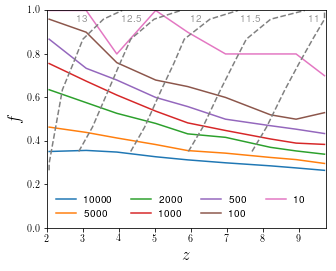

In [83]:
fig, ax = plt.subplots(figsize=(5,4))
        
for j, n in enumerate(N):
    ax.plot([float(x.replace('p','.')) for x in zees], frac[j], label='%s'%n)

for i in range(5):
    ax.plot(mass_curves[:,0,i], mass_curves[:,1,i],
            color='grey', linestyle='dashed')
    

ax.text(9.3, 0.95, 11, color='grey', alpha=0.8)
ax.text(7.4, 0.95, 11.5, color='grey', alpha=0.8)
ax.text(6, 0.95, 12, color='grey', alpha=0.8)
ax.text(4.1, 0.95, 12.5, color='grey', alpha=0.8)
ax.text(2.85, 0.95, 13, color='grey', alpha=0.8)
    
ax.set_ylim(0, 1)
ax.set_xlim(2, 9.75)

ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$f$', size=17)

ax.legend(frameon=False, prop={'size':10}, ncol=4)

# plt.savefig('../papers/protoclusters/images/halo_fractions.png', bbox_inches='tight', dpi=300)

Find largest and main progenitors for $z = 0$ selections

In [42]:
idx_zn_largest = dict.fromkeys(zees)
idx_zn_main = dict.fromkeys(zees)

for z in zees[:5]:
    
    idx_zn_largest[z] = z0_halos[z].groupby(['z0_haloId'])['zn_m_crit200'].idxmax().values
    idx_zn_main[z] = (z0_halos[z]['zn_haloId'] <= z0_halos[z]['z0_mainLeafId']) & \
                     (z0_halos[z]['zn_haloId'] > z0_halos[z]['z0_haloId'])

In [58]:
print z

np.sum(zn_halos[z][:2000]['m_crit200'] < 1e13) / 2000.

5p92


0.012

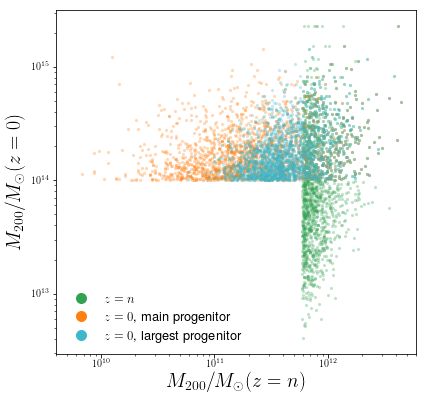

In [49]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_axes([0,0,1,1])

z = '5p92'

ax.scatter('zn_m_crit200', 'm_crit200', data=zn_halos[z][:2000], marker='o', s=10, alpha=0.3, lw=0,c=cmap[0])

ax.scatter('zn_m_crit200', 'z0_m_crit200', data=z0_halos[z].ix[idx_zn_main[z]], marker='o', 
           s=10, alpha=0.3, lw=0, c=cmap[2])

ax.scatter('zn_m_crit200', 'z0_m_crit200', data=z0_halos[z].ix[idx_zn_largest[z]], marker='o',
           s=10, alpha=0.3, lw=0, c=cmap[4])

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_aspect('equal') # overrides figsize

ax.set_xlim(4e9, 6e12)
# ax.set_ylim(3e12, 3e15)

line1 = plt.Line2D(range(1), range(1), color=cmap[0], marker='o', markersize=10, linestyle='')
line2 = plt.Line2D(range(1), range(1), color=cmap[2], marker='o', markersize=10, linestyle='')
line3 = plt.Line2D(range(1), range(1), color=cmap[4], marker='o', markersize=10, linestyle='')

legend = ax.legend([line1, line2, line3],
                   ['$z = n$', '$z = 0$, main progenitor','$z = 0$, largest progenitor'], 
                   loc=3, prop={'size': 13}, markerscale=1)

legend.get_frame().set_edgecolor('white')


ax.set_xlabel('$M_{200} / M_{\odot} (z = n)$', size=20)
ax.set_ylabel('$M_{200} / M_{\odot} (z = 0)$', size=20)

# plt.savefig('../papers/protoclusters/images/fof_evolution_z6_z0.png', bbox_inches='tight', dpi=300)

### z0 subsets

Find largest z = 6 descendant

In [28]:
idx_z6largest = z0_halos.groupby(['z0_haloId'])['z6_m_crit200'].idxmax().values
# z0_halos.ix[idx_z6largest]

AttributeError: 'dict' object has no attribute 'groupby'

z = 6 decendants on the main branch

In [29]:
idx_z6main = (z0_halos['z6_haloId'] <= z0_halos['z0_mainLeafId']) & (z0_halos['z6_haloId'] > z0_halos['z0_haloId'])
# z0_halos[idx_z6main]

KeyError: 'z6_haloId'

Number of z=6 objects that end up in z=0 clusters

In [80]:
float(sum(z6_halos['z0_m_crit200'] > z0_halos.ix[idx_z6largest]['z0_m_crit200'].min())) / len(z6_halos['z0_m_crit200'])

0.42319949012109626

Number of z=0 clusters that have a large z=6 halo progenitor

In [81]:
float(sum(z0_halos.ix[idx_z6largest]['z6_m_crit200'] > z6_halos['z6_m_crit200'].min())) / len(z0_halos.ix[idx_z6largest]['z6_m_crit200'])

0.3838951310861423

Number of z=0 clusters that have a large z=6 halo progenitor on their main branch

In [82]:
float(sum(z0_halos.ix[idx_z6main]['z6_m_crit200'] > z6_halos['z6_m_crit200'].min())) / len(z0_halos.ix[idx_z6main]['z6_m_crit200'])

0.22683397683397682

### plots

NameError: name 'z6_halos' is not defined

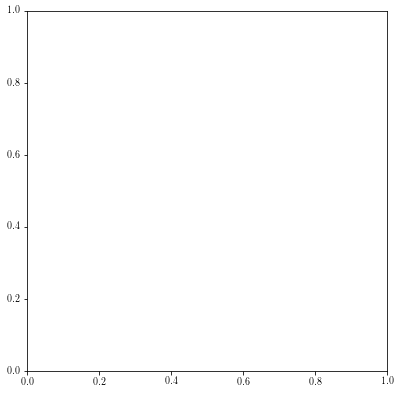

In [30]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_axes([0,0,1,1])

ax.scatter('z6_m_crit200', 'z0_m_crit200', data=z6_halos, marker='o', s=10, alpha=0.3, lw=0,c=cmap[0])

ax.scatter('z6_m_crit200', 'z0_m_crit200', data=z0_halos.ix[idx_z6main], marker='o', 
           s=10, alpha=0.3, lw=0, c=cmap[2])

ax.scatter('z6_m_crit200', 'z0_m_crit200', data=z0_halos.ix[idx_z6largest], marker='o',
           s=10, alpha=0.3, lw=0, c=cmap[4])

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_aspect('equal') # overrides figsize

ax.set_xlim(4e9, 6e12)
ax.set_ylim(3e12, 3e15)

line1 = plt.Line2D(range(1), range(1), color=cmap[0], marker='o', markersize=10, linestyle='')
line2 = plt.Line2D(range(1), range(1), color=cmap[2], marker='o', markersize=10, linestyle='')
line3 = plt.Line2D(range(1), range(1), color=cmap[4], marker='o', markersize=10, linestyle='')

legend = ax.legend([line1, line2, line3],
                   ['$z = 6$', '$z = 0$, main progenitor','$z = 0$, largest progenitor'], 
                   loc=3, prop={'size': 13}, markerscale=1)

legend.get_frame().set_edgecolor('white')


ax.set_xlabel('$M_{200} / M_{\odot} (z = 6)$', size=20)
ax.set_ylabel('$M_{200} / M_{\odot} (z = 0)$', size=20)

# plt.savefig('../papers/hightolowz/images/fof_evolution_z6_z0.png', bbox_inches='tight', dpi=300)

add lines to above plot...

In [ ]:
aggdata = dat_z6top.groupby(['z0_haloId']).agg(['mean','count','max','min'])
aggdata = aggdata.reset_index()

In [ ]:
ax.errorbar(x=aggdata['z6_m_crit200']['mean'][aggdata['z0_m_crit200']['mean'] > 1e15],
             y=aggdata['z0_m_crit200']['mean'][aggdata['z0_m_crit200']['mean'] > 1e15],
             xerr=[aggdata['z6_m_crit200']['mean'][aggdata['z0_m_crit200']['mean'] > 1e15]-aggdata['z6_m_crit200']['min'][aggdata['z0_m_crit200']['mean'] > 1e15],
                   aggdata['z6_m_crit200']['max'][aggdata['z0_m_crit200']['mean'] > 1e15]-aggdata['z6_m_crit200']['mean'][aggdata['z0_m_crit200']['mean'] > 1e15]],
             fmt='None', alpha=0.1, capsize=0, c='black', label='')